In [99]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, r2_score
from copy import deepcopy

#Change the default pandas display to allow 35 columns
pd.set_option('display.max_columns', 35)
pd.set_option('display.max_rows', 35000)

In [2]:
#Get the file names
os.chdir("../data")
files = glob("*.csv")
files.sort()       
files = files[:-1]          #Leave off 2020 because we won't use it
os.chdir("../scratchpad")

#Split them into train and test files
train_files = files[:-1]
test_files = files[-1:]
print(f"Train files: {train_files}")
print(f"Test files: {test_files}")

#Set the number of year
sequence_length = len(train_files)
print(f"Sequence length: {sequence_length}")

Train files: ['All_Traffic 2011.csv', 'All_Traffic 2012.csv', 'All_Traffic 2013.csv', 'All_Traffic 2014.csv', 'All_Traffic 2015.csv', 'All_Traffic 2016.csv', 'All_Traffic 2017.csv', 'All_Traffic 2018.csv']
Test files: ['All_Traffic 2019.csv']
Sequence length: 8


In [3]:
X_list = []

for file in files:
    #Read in the data
    df = pd.read_csv(os.path.join("../data", file))
    
    #Drop any rows with missing values
    df.dropna(axis = 0, inplace = True)
    
    #Add the year to the data
    df["Year"] = file[12:16]
    
    #Add the path to the data and drop the origin and destination columns
    df["Path"] = "(" + df["BEA_origin"].astype("str") + ", " + df["BEA_dest"].astype("str") + ")"
    df = df.drop(columns = ["BEA_origin", "BEA_dest"], inplace = False).reset_index(drop = True)
    
    X_list.append(df)

#Concatenate the data together
X_all = pd.concat(X_list, axis = 0, copy = False)
X_all.sort_values(by = ["Path", "Year"], inplace = True)
    

In [4]:
#Get your X and y data
y = X_all["log_carloads"][X_all["Year"] == "2019"]
X = X_all[X_all["Year"] != "2019"]
X = X.drop(["Path", "Average_Mileage", "Year"], axis = 1)

In [18]:
#Define the size of your training dataset
train_size = int(X.index.nunique() * .8)

#Get the indices for the train and test data
train_indices = random.sample(range(0, X.index.nunique()), train_size)
test_indices = list(set(range(0, X.index.nunique())) - set(train_indices))

#Get the train and test data
X_train = X.loc[train_indices, :]
X_test = X.loc[test_indices, :]
y_train = y.loc[train_indices]
y_test = y.loc[test_indices]

#Scale the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index).values
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index).values

#Convert the data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float32)


In [24]:
class MyDataset(Dataset):
    def __init__(self, indices):
        self.indices = indices
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        start = idx * sequence_length
        return np.arange(start, start + sequence_length), idx
    
#Create the datasets
train_dataset = MyDataset(train_indices)
test_dataset = MyDataset(test_indices)

#Create the dataloaders 
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [129]:
#Define the CNN
class CNN(nn.Module):
    def __init__(self, initial_channel_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = initial_channel_size, out_channels = 64, kernel_size = 2, padding = "same")
        self.conv2 = nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = 2, padding = "same")    
        self.ln1 = nn.LayerNorm(64)
        self.ln2 = nn.LayerNorm(64)
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool1d(kernel_size = 2)
        
        self.conv3 = nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 2, padding = "same")
        self.conv4 = nn.Conv1d(in_channels = 128, out_channels = 64, kernel_size = 2, padding = "same")
        self.ln3 = nn.LayerNorm(128)
        self.ln4 = nn.LayerNorm(64)
        
        self.linear1 = nn.Linear(128, 32)
        self.linear2 = nn.Linear(32, 1)
         
    def forward(self, x):
        x = self.activation(self.ln1(self.conv1(x).permute(0,2,1)).permute(0,2,1))
        x = self.dropout(x)
        x = self.activation(self.ln2(self.conv2(x).permute(0,2,1)).permute(0,2,1))
        x = self.pool(x)
        x = self.activation(self.ln3(self.conv3(x).permute(0,2,1)).permute(0,2,1))
        x = self.dropout(x)
        x = self.activation(self.ln4(self.conv4(x).permute(0,2,1)).permute(0,2,1))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.activation(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x).squeeze()

        return x

In [130]:
#Instantiate the model, define the optimizer and loss function
model = CNN(X_train_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)
loss = nn.MSELoss()

In [124]:
@torch.no_grad()
def eval(model, data_x, data_y, loader):
    model.eval()
    y_list = []
    y_pred_list = []
    
    for x_inds, y_inds in loader:
        #Get the current data
        current_x = data_x[x_inds].permute(0,2,1)
        current_y = data_y[y_inds]

        #Get the predictions
        y_pred = model(current_x)
        
        #Append the data
        y_list.append(current_y)
        y_pred_list.append(y_pred)

    #Create the final vectors
    final_y = torch.cat(y_list).numpy()
    final_y_pred = torch.cat(y_pred_list).numpy()
    
    #Calculate the loss and r2
    eval_loss = mean_squared_error(final_y, final_y_pred)
    eval_r2 = r2_score(final_y, final_y_pred)
    
    return eval_loss, eval_r2

In [131]:
#Training loop
max_epochs = 1000
train_loss_list = []
test_loss_list = []
test_r2_list = []
patience = 35
best_model = None
best_r2 = -np.inf
patience_counter = 0

for epoch in range(max_epochs):
    epoch_train_loss_list = []
    for x_inds, y_inds in train_dataloader:
        #Grab the data
        current_x = X_train_tensor[x_inds].permute(0,2,1)
        current_y = y_train_tensor[y_inds]
        
        #Pass the data through the model
        model.train()
        optimizer.zero_grad()
        y_guess = model(current_x)
        
        #Calculate and record the loss
        current_loss = loss(y_guess, current_y)
        current_loss.backward()
        epoch_train_loss_list.append(current_loss.item())
        
        #Update the weights
        optimizer.step()
        
        
    train_loss_list.append(np.mean(epoch_train_loss_list))
        
    #Evaluate and record the model on the test data
    test_loss, test_r2 = eval(model, X_test_tensor, y_test_tensor, test_dataloader)
    test_loss_list.append(test_loss)
    test_r2_list.append(test_r2)
    
    #Evaluate whether to stop or not
    if test_r2 > best_r2:
        best_model = deepcopy(model)
        best_r2 = test_r2
        patience_counter = 0
    else:
        patience_counter += 1
        
    print(f"Epoch: {epoch}, Train Loss: {train_loss_list[-1]}, Test Loss: {test_loss_list[-1]}, Test R2: {test_r2_list[-1]}")
    
    if patience_counter > patience:
        final_epoch = epoch
        print(f"Early stopping at epoch {epoch}")
        break
    else:
        final_epoch = epoch



Epoch: 0, Train Loss: 13.520219439551944, Test Loss: 5.9521098136901855, Test R2: 0.5994879603385925
Epoch: 1, Train Loss: 7.18631713163285, Test Loss: 6.3738603591918945, Test R2: 0.5711086988449097
Epoch: 2, Train Loss: 5.725722687585013, Test Loss: 5.1022491455078125, Test R2: 0.6566742658615112
Epoch: 3, Train Loss: 5.541014327889397, Test Loss: 5.308671951293945, Test R2: 0.6427842974662781
Epoch: 4, Train Loss: 5.325152391479129, Test Loss: 4.445508003234863, Test R2: 0.7008658051490784
Epoch: 5, Train Loss: 4.824492562384832, Test Loss: 4.687805652618408, Test R2: 0.6845618486404419
Epoch: 6, Train Loss: 4.813303902035668, Test Loss: 5.45683479309082, Test R2: 0.6328145265579224
Epoch: 7, Train Loss: 4.998452873457046, Test Loss: 4.3833394050598145, Test R2: 0.7050490975379944
Epoch: 8, Train Loss: 4.9977557602382845, Test Loss: 4.692371368408203, Test R2: 0.6842545866966248
Epoch: 9, Train Loss: 4.864058744339716, Test Loss: 4.343515872955322, Test R2: 0.7077287435531616
Epoch:

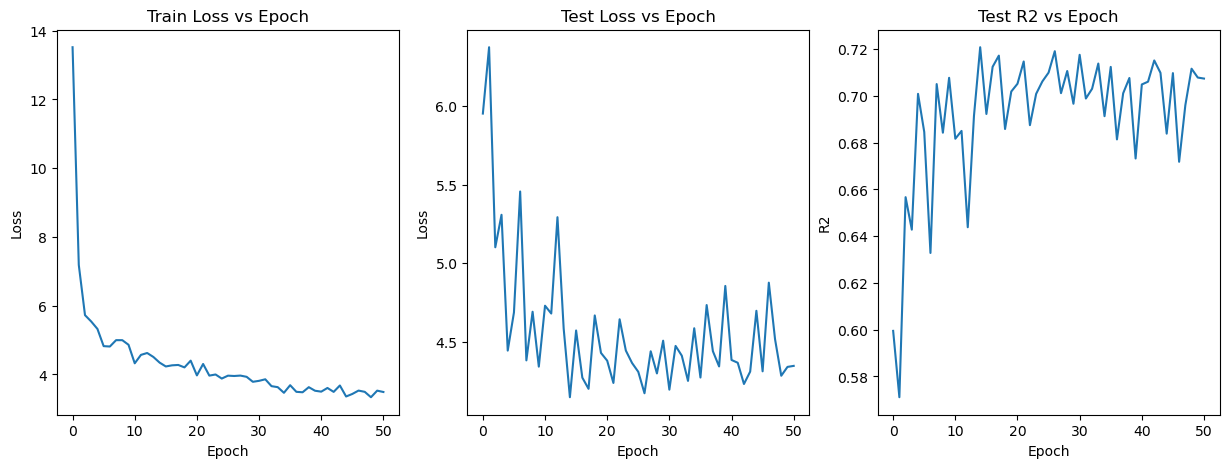

Best R2: 0.721, Lowest Loss: 4.14900016784668


In [132]:
num_epochs = final_epoch + 1
fig, axes = plt.subplots(1,3, figsize = (15,5))
axes[0].plot(np.arange(num_epochs), train_loss_list)
axes[0].set_title("Train Loss vs Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

axes[1].plot(np.arange(num_epochs), test_loss_list)
axes[1].set_title("Test Loss vs Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

axes[2].plot(np.arange(num_epochs), test_r2_list)
axes[2].set_title("Test R2 vs Epoch")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("R2")
plt.show()

print(f"Best R2: {round(best_r2,3)}, Lowest Loss: {round(np.min(test_loss_list),3)}")